In [ ]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve

# Data Loading

In [ ]:
# connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_clean_data = "Image Numpys_saved/"

# load data
X_train = np.load(folder_clean_data + 'X_train_resampled.npy')
y_train = np.load(folder_clean_data + 'y_train_resampled.npy')
X_val = np.load(folder_clean_data + 'X_val_resampled.npy')
y_val = np.load(folder_clean_data + 'y_val_resampled.npy')
X_test = np.load(folder_clean_data + 'X_test_pix.npy')
y_test = np.load(folder_clean_data + 'y_test.npy')

In [ ]:
# check the size of the train, validation and test set
print(f"""
X train shape: {X_train.shape}
y train shape: {y_train.shape}
X validation shape: {X_val.shape}
y validation shape: {y_val.shape}
X test shape: {X_test.shape}
y test shape: {y_test.shape}
""")


X train shape: (6043, 128, 128, 3)
y train shape: (6043,)
X validation shape: (2042, 128, 128, 3)
y validation shape: (2042,)
X test shape: (1491, 128, 128, 3)
y test shape: (1491,)



In [ ]:
# merge train and validation (as cross validation cv is used)
X_train_merged = np.concatenate((X_train, X_val), axis=0)
y_train_merged = np.concatenate((y_train, y_val), axis=0)
X_train_merged.shape

(8085, 128, 128, 3)

# (Data Augmentation)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = X_train_merged.shape[0]

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
    )

# Create generators for training and test data
train_generator = datagen.flow(
    x= X_train_merged,
    y= y_train_merged,
    batch_size= batch_size
)

In [ ]:
# transform to a numpy array to be used for scikit-learn classifiers
len_dataset = X_train_merged.shape[0]
num_clases = 2
# define the factor by which the dataset should be augmented
augmentation_factor = 2

# generate empty arrays to append
X_train_aug = np.empty((batch_size * augmentation_factor, 
                        X_train_merged.shape[1], 
                        X_train_merged.shape[2], 
                        X_train_merged.shape[3]))

y_train_aug = np.empty((batch_size * augmentation_factor))

# append the generated images to the arrays
for i in range(augmentation_factor):
    x_batch, y_batch = train_generator.next()
    for j in range(x_batch.shape[0]): # number of images for each batch
        X_train_aug[i*x_batch.shape[0]+j] = x_batch[j]
        y_train_aug[i*x_batch.shape[0]+j] = y_batch[j]

In [ ]:
# plot some of the augmented images
fig = plt.figure(figsize=(7,10))

for i in range(15):
    index = random.randint(0,X_train_aug.shape[0])
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_aug[index])
    plt.title(y_train_aug[index])
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

# Dimensionality Reduction

In [ ]:
# reshape the arrays 
X_train_reshaped = X_train_merged.reshape(X_train_merged.shape[0],-1)
X_test_reshaped = X_test.reshape(X_test.shape[0],-1)

print("X train shape: ", X_train_reshaped.shape)
print("X test shape: ", X_test_reshaped.shape)

X train shape:  (8085, 49152)
X test shape:  (1491, 49152)


In [ ]:
# reduce the dimensionality: applying PCA to the dataset while perserving 99% of it's variance
pca = PCA(n_components=0.99)

In [ ]:
%%time
X_train_reduced = pca.fit_transform(X_train_reshaped)
X_test_reduced = pca.transform(X_test_reshaped)

CPU times: user 22min 46s, sys: 3min 19s, total: 26min 6s
Wall time: 7min 23s


In [ ]:
print("X train shape:", X_train_reduced.shape)
print("X test shape:", X_test_reshaped.shape)

X train shape: (8085, 462)
X test shape: (1491, 49152)


# Grid search

In [ ]:
# subset the training set to perform grid search faster
X_train_reshaped_subset = X_train_reduced[:3000, :]
y_train_merged_subset = y_train_merged[:3000]

In [ ]:
# Instantiate the SVC model
svm_clf = SVC()

In [ ]:
# define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000], # Regularization parameter, controls the margin hardness
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly','rbf','linear']} # kernel type to be used

# performs grid search with cross validation to search the best combination of hyperparameter values
grid_svm = GridSearchCV(svm_clf, param_grid, return_train_score=True, n_jobs=-1, cv=3, verbose=10)

In [ ]:
%%time
grid_svm.fit(X_train_reshaped_subset, y_train_merged_subset)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
CPU times: user 6.98 s, sys: 772 ms, total: 7.76 s
Wall time: 17min 25s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly', 'rbf', 'linear']},
             return_train_score=True, verbose=10)

In [ ]:
# best estimator
print("Best parameters:", grid_svm.best_params_)
print("Best score:", grid_svm.best_score_)

# save the best estimator as the model
model_svc = grid_svm.best_estimator_

Best parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best score: 0.9163333333333333


# Randomized Grid search

In [ ]:
# Instantiate the SVC model
svm_clf = SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000], # Regularization parameter, controls the margin hardness
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], #stats.expon(scale=.01), 
              'kernel': ['poly','rbf','linear']} # kernel type to be used

grid_svm_rand = RandomizedSearchCV(svm_clf, param_grid, verbose=10, cv=5, n_iter=10, n_jobs=-1, random_state=42)

In [ ]:
%%time
grid_svm_rand.fit(X_train_reshaped_subset, y_train_merged_subset)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2.63 s, sys: 195 ms, total: 2.83 s
Wall time: 4min 3s


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['poly', 'rbf', 'linear']},
                   random_state=42, verbose=10)

In [ ]:
# best estimator
print("Best parameters:", grid_svm_rand.best_params_)
print("Best score:", grid_svm_rand.best_score_)

# save the best estimator as the model
#model_svc = grid_svm_rand.best_estimator_

Best parameters: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1}
Best score: 0.8563333333333333


# Predict and Evaluate

## SVM without augmentation

In [ ]:
# Run this cell to not do grid search again
#model_svc = SVC(C=100, gamma=0.0001, kernel='rbf')
#model_svc.fit(X_train_reduced, y_train_merged)

In [1]:
### run this cell to load the model###
import pickle

filename = "Models/SVM_model.pickle"

# load model
model_svc = pickle.load(open(filename, "rb"))

/Users/MiraMetzger/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [ ]:
y_pred = model_svc.predict(X_test_reduced)

In [ ]:
# Access the associated confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print performance measures  
print('Accuracy (simple):', accuracy_score(y_test, y_pred))
measures_info = classification_report(y_test, y_pred)
print('Accuracy (extended):\n' + measures_info)

[[428  63]
 [ 46 954]]
Accuracy (simple): 0.9268947015425889
Accuracy (extended):
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       491
           1       0.94      0.95      0.95      1000

    accuracy                           0.93      1491
   macro avg       0.92      0.91      0.92      1491
weighted avg       0.93      0.93      0.93      1491



### ROC Curve (Train)

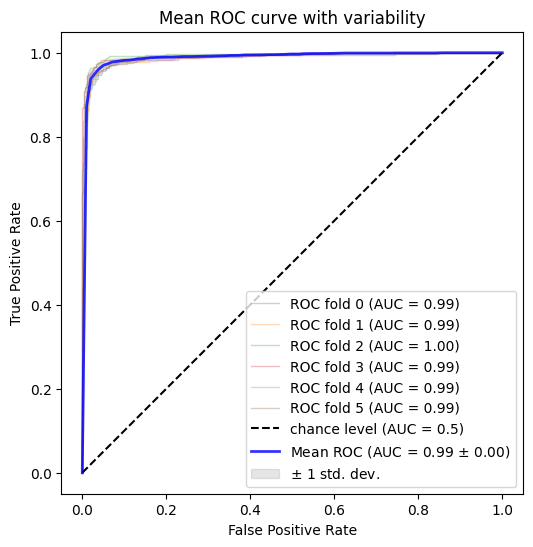

In [ ]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_train_reduced, y_train_merged)):
    model_svc.fit(X_train_reduced[train], y_train_merged[train])
    viz = RocCurveDisplay.from_estimator(
        model_svc,
        X_train_reduced[test],
        y_train_merged[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

AUC: 0.9876457772337821


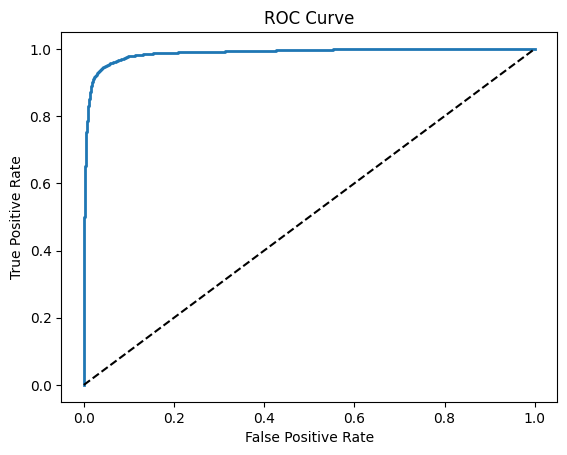

In [ ]:
from sklearn.model_selection import cross_val_predict

y_score = cross_val_predict(model_svc, X_train_reduced, y_train_merged, cv=3, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_merged, y_score)
print('AUC:', (roc_auc_score(y_train_merged, y_score)))

# plot the roc curve
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # add the diagonal line
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc(fpr, tpr)
plt.show()

## ROC Curve (Test)

AUC: 0.9773523421588595


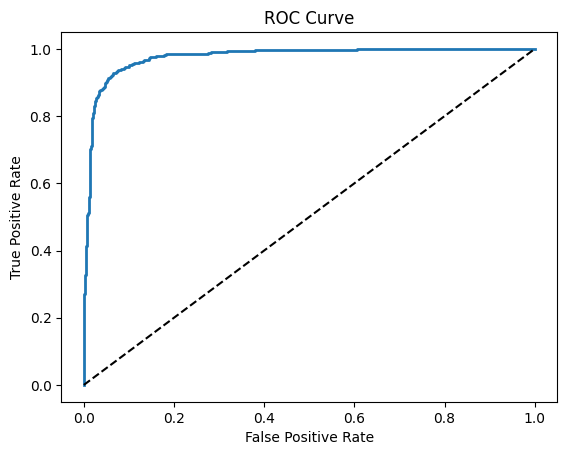

In [ ]:
from sklearn.metrics import roc_auc_score

decision_scores = model_svc.decision_function(X_test_reduced)

fpr, tpr, thresholds = roc_curve(y_test, decision_scores)
print('AUC:', (roc_auc_score(y_test, decision_scores)))

plot_roc(fpr, tpr)
plt.show()

## Save the model

In [ ]:
### uncomment and run this code to save the model###
#filename = "Models/SVM_model.pickle"
#pickle.dump(model_svc, open(filename, "wb"))

# Further Model Experiments

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier()

param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

param_grid = { 
    'n_estimators': [600, 800, 1000],
    'max_features': ['auto'],
    'max_depth' : [40, 50, 60, 70, 80],
    'criterion' :['entropy']
}

# defining parameter range
grid_rnd = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=10, n_jobs = -1)
  
# fitting the model for grid search
grid_rnd.fit(X_train_reshaped_small, y_train_merged)

In [ ]:
# best estimator
print("Best parameters:", grid_rnd.best_params_)
print("Best score:", grid_rnd.best_score_)

# save the best estimator as the model
model_svc = grid_rnd.best_estimator_